In [1]:
from naslib.utils.io import read_json
from pathlib import Path 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.axes import Axes

In [2]:
sns.set_style("white")
rcParams['axes.titlepad'] = 15
rcParams['font.size'] = 9

In [3]:
QUERY_VAL_ACC = "valid_acc"
QUERY_CAL_ERR = "calibration_score" 
LOG_FILENAME = "errors.json"

def collect_json_info_all_seeds(folder: Path, filename: str = LOG_FILENAME, query_key: str = QUERY_CAL_ERR):
    matches = list(folder.rglob(pattern=f"./seed=*"))

    scores={}
    for p in matches:
        scores[p.name] = read_json(p / filename)[query_key]
    df = pd.DataFrame(scores)
    df.index += 1   # python indexing starts from 0
    df.index.name = "epochs"
    return df.sort_index(axis=1)

In [4]:
def plot_json_single_experiment(path: Path, ax: Axes, label: str | None, query_key: str, ylabel: str, start_epoch=0, dahses = None):
    df_wide = collect_json_info_all_seeds(folder=path, query_key=query_key)     
    mean = df_wide.iloc[-1, :].mean()
    std = df_wide.iloc[-1, :].std()

    df_wide = df_wide.reset_index()    
    df_wide = df_wide[df_wide["epochs"] >= start_epoch]
    df_long = pd.melt(df_wide, id_vars='epochs')
    legend = None if label is None else "auto"

    label = f"{label}: mean={round(mean, 3)}, std={round(std, 4)}"
    sns.lineplot(x="epochs", data=df_long, y="value", err_style="band", errorbar="sd", label=label, ax=ax, legend=legend, alpha=0.8, dashes=dahses)
    ax.set_xlabel("epochs")
    ax.set_ylabel(ylabel=ylabel)
    ax.tick_params(labelbottom=True)
    return ax

In [68]:
datasets = ["CIFAR10" , "CIFAR100", "ImageNet16-120"]
home = Path.home() / "Desktop/Experiments"

def get_label_and_path(dataset): 
    if "CIFAR" in dataset:
        dataset = dataset.lower()
    exp_0 = home/"acq_search=mutation/nasbench201" / dataset / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__gaussian__num_quantiles=10"
    exp_1 = home/"acq_search=mutation/nasbench201" / dataset  / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__CP_split__train_cal_split=05__num_quantiles=10"
    exp_2 = home/"acq_search=mutation/nasbench201" / dataset  / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__CP_cv__train_cal_split=3__num_quantiles=10"
    exp_3 = home/"acq_search=mutation/nasbench201" / dataset  / "acq=its/num_to_mutate=2/num_init=10/bananas__ensemble_mlp__CP_bootstrap__num_ensemble=5__num_quantiles=10_absresidual"

    label_and_path = {
        "uncalibrated": exp_0,
        "scp": exp_1,
        "cross-val cp": exp_2,
        "bootstrap cp": exp_3
   #     "cross-val cp (acq=EI)": exp_2,
    #    "uncalibrated (random sampling)": exp_3,
    #    "scp (acq=EI)": exp_3,
    #    "scp (acq=PI)": exp_4,
    }
    return label_and_path

### Visualise validation accuracy and RMSCE per epoch

In [60]:
color_set = [
    "#377EB8",  # blue
    "#4DAF4A",  # green
    "#FF7F00",  # orange
    "#984EA3",  # purple
    "#E41A1C",  # red
  #  "#FFD92F",  # yellow
 #   "#00CED1",  # cyan/turquois
]

# Set as default cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_set)

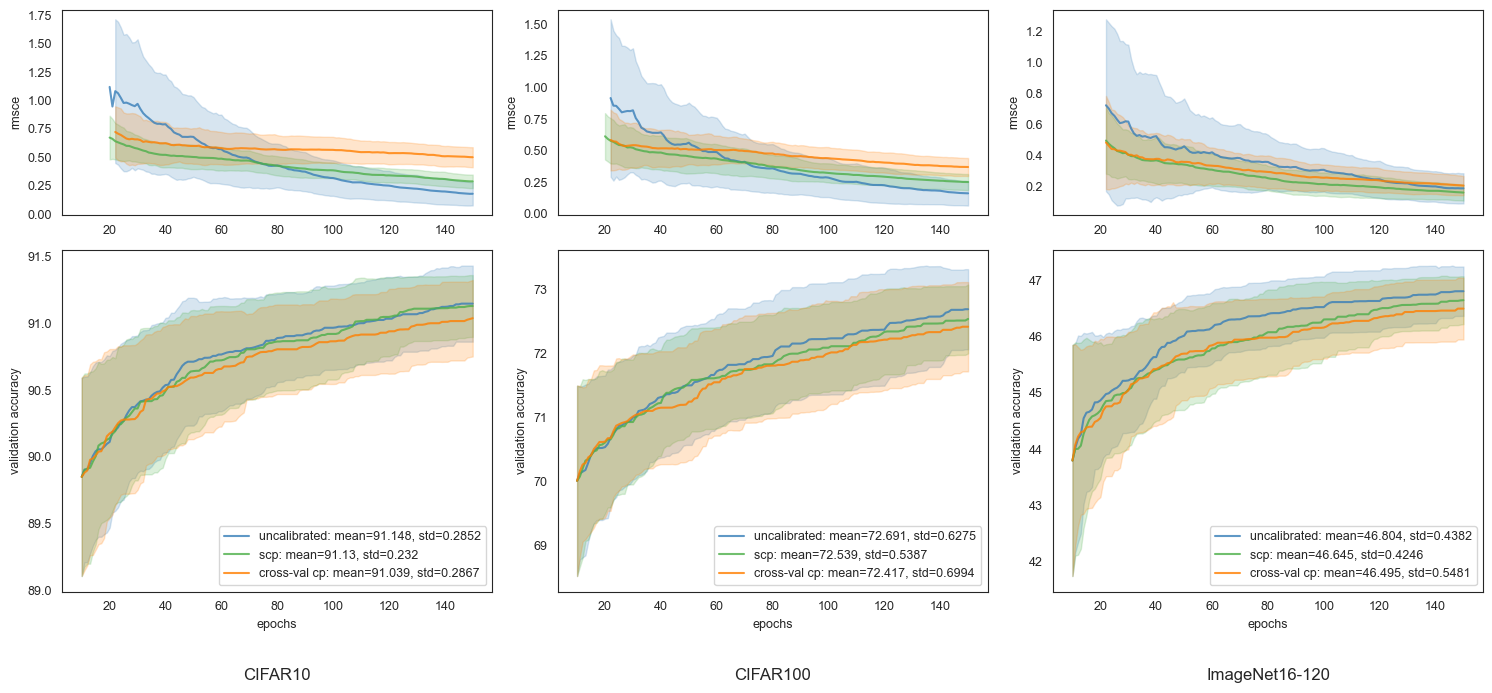

In [61]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 7),sharex=True, gridspec_kw={"height_ratios" : [1.5, 2.5]})
start_epoch = 10


for i, dataset in enumerate(datasets):
    label_and_path = get_label_and_path(dataset=dataset)
    for label, path in label_and_path.items():
        plot_json_single_experiment(path=path, ax=axes[0, i], label=None, query_key=QUERY_CAL_ERR, ylabel="rmsce", start_epoch=start_epoch)
        plot_json_single_experiment(path=path, ax=axes[1, i], label=label, query_key=QUERY_VAL_ACC, ylabel="validation accuracy", start_epoch=start_epoch)
        axes[1, i].legend(loc="lower right")
        axes[1, i].set_title(dataset, y=0, pad=-55, verticalalignment="top", fontsize=12)
plt.tight_layout()

###  Predictions

#### Predict Errors for Ensemble Predictor

In [ ]:
import pickle
import numpy as np
from naslib.optimizers.bananas.calibration_utils import ConditionalEstimation

def get_ensmeble_mlp_pred_abs_errors(path):
    with open(path, "rb") as f:
        _, obs_and_dist = pickle.load(f)
        obs_and_dist_unpacked = list(zip(*obs_and_dist))
        y_true = list(obs_and_dist_unpacked[0])
        y_pred = [np.mean(item.point_prediction) if isinstance(item, ConditionalEstimation) else np.nan for item in obs_and_dist_unpacked[1]]
        return  abs(np.array(y_pred) - np.array(y_true))
    
def collect_preds_all_seeds(folder: Path):
    matches = list(folder.rglob(pattern=f"./seed=*"))
    errors ={}
    for p in matches:
        errors[p.name] = get_ensmeble_mlp_pred_abs_errors(path=p / "search_log.pt")
    df = pd.DataFrame(errors)
    df.index += 1   # python indexing starts from 0
    df.index.name = "epochs"
    return df.sort_index(axis=1)


def plot_preds_single_experiment(path: Path, ax: Axes, label: str | None, ylabel: str, start_epoch=0, smooth_window=10):
    df_wide = collect_preds_all_seeds(folder=path)
    mean = np.nanmean(df_wide.values)
    std = np.nanstd(df_wide.values)

    df_wide = df_wide.reset_index()    
    df_wide = df_wide[df_wide["epochs"] >= start_epoch].rolling(10).mean()
    df_long = pd.melt(df_wide, id_vars='epochs')
    legend = None if label is None else "auto"

    label = f"{label}: mean={round(mean, 3)}, std={round(std, 4)}"
    sns.lineplot(x="epochs", data=df_long, y="value", err_style="band", errorbar="sd", label=label, ax=ax, legend=legend, alpha=0.8, dashes=dahses)
    ax.set_xlabel("epochs")
    ax.set_ylabel(ylabel=ylabel)
    ax.tick_params(labelbottom=True)
    return ax

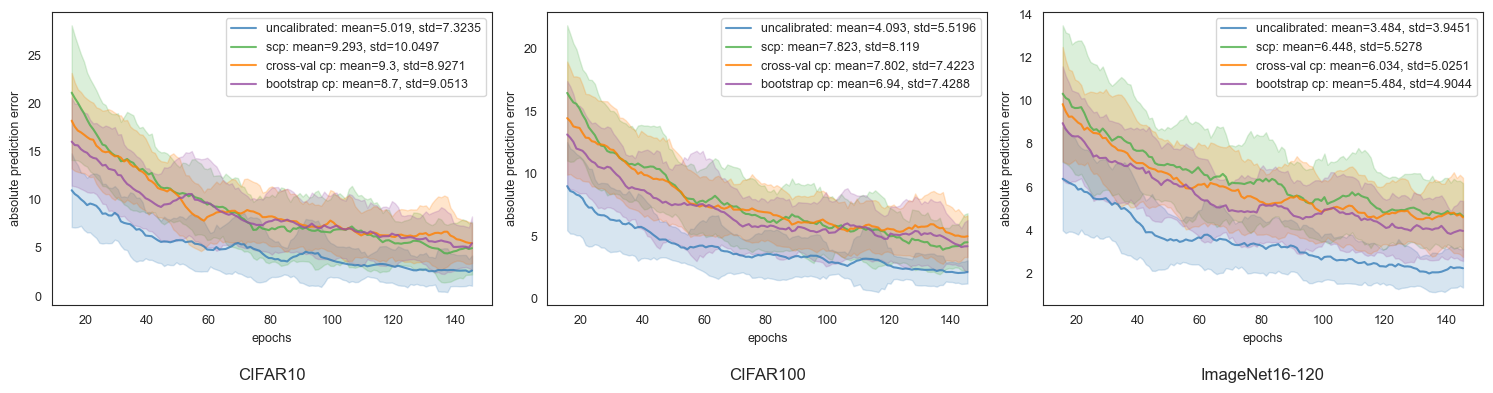

In [74]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
start_epoch = 0

for i, dataset in enumerate(datasets):
    label_and_path = get_label_and_path(dataset=dataset)
    for label, path in label_and_path.items():
        plot_preds_single_experiment(path=path, ax=axes[i], label=label, ylabel="absolute prediction error",  start_epoch=start_epoch)
        axes[i].set_title(dataset, y=0, pad=-45, verticalalignment="top", fontsize=12)
plt.tight_layout()